# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from collections import deque
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# Import Unity game environment
from unityagents import UnityEnvironment

# Import DDPG agent
from ddpg_agent import Agent

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.10349999768659472


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
# Define a training function
def ddpg(n_episodes=500, max_t=1000, checkpoint_a='checkpoint_actor.pth', checkpoint_c='checkpoint_critic.pth'):
    """Deep Deterministic Policy Gradient Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        checkpoint_a (str): name of the actor checkpoint path
        checkpoint_c (str): name of the critic checkpoint path
    """
    scores_total = []
    scores_window = deque(maxlen=100)
    average_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset the environment
        states = env_info.vector_observations                   # get the current state
        agent.reset()                                           # reset the agent noise
        scores = np.zeros(num_agents)                           # initialize the score
        for t in range(max_t):
            actions = agent.act(states)                         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                                # roll over state to next time step
            scores += rewards                                   # update the score
            if np.any(dones):                                   # exit loop if episode finished
                break 
        scores_window.append(scores)                   # save most recent score
        scores_total.append(scores)                    # save most recent score
        average_scores.append(np.mean(scores_window))  # save most recent average score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), checkpoint_a)
            torch.save(agent.critic_local.state_dict(), checkpoint_c)
            break
    return scores_total, average_scores

In [7]:
# Define a plotting function
def plot_scores(scores, average_scores, title):
    """Plot the agent's rewards across training episodes.
    
    Params
    ======
        scores (float): scores obtained in each episode
        average_scores (float): mean value of scores over every 100 episodes
        title (str): title of the plot
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, alpha=0.5)
    plt.plot(np.arange(len(scores)), average_scores, linewidth=1.5, c='r')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.title(title)
    plt.show()
    return fig

Episode 100	Average Score: 26.68
Episode 109	Average Score: 30.07
Environment solved in 9 episodes!	Average Score: 30.07
CPU times: user 50min 29s, sys: 1min 21s, total: 51min 51s
Wall time: 55min 43s


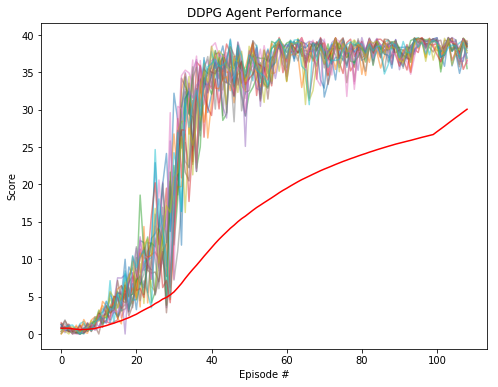

In [8]:
# Train a deep deterministic policy gradient agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
%time scores, average_scores = ddpg(checkpoint_a='checkpoint_actor.pth', checkpoint_c='checkpoint_critic.pth')

# Plot the scores
figure = plot_scores(scores, average_scores, 'DDPG Agent Performance')

In [9]:
# Load the saved network weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [10]:
# Test the trained DDPG agent
def ddpg_test(n_episodes=1, max_t=1000):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations   
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]     
            next_states = env_info.vector_observations   
            rewards = env_info.rewards                   
            dones = env_info.local_done                  
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break
        print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

scores = ddpg_test()

Total score (averaged over agents) this episode: 38.47699913997203
